# Tesseract 기반 문서 인식 (OCR) + OpenCV 활용

이 노트북은 **Tesseract**를 이용해 문서 이미지를 인식(OCR)하고, **OpenCV**의 전처리 기법을 활용하여 인식 성능을 높이는 방법을 다룹니다.

## 주요 내용
1. **Tesseract** 란?
2. **설치** 및 **기본 사용**
3. **이미지 전처리**를 통한 성능 향상 (그레이스케일, 이진화, 노이즈 제거 등)
4. **영역별 텍스트 추출** (위치·신뢰도)
5. **다국어 문서 인식** (언어 모델 설치)
6. **PDF 문서 처리** (pdf2image를 통해 페이지 단위 이미지 변환 후 OCR)
7. **과제**: 추가 실습 아이디어 & 예시 코드

Colab 환경에서 GUI 창을 띄우는 대신, `cv2_imshow`를 사용하여 이미지를 시각화합니다.

# 1. Tesseract란?
**Tesseract**는 Google이 지원하는 **OCR(Optical Character Recognition)** 엔진입니다.
- 이미지를 입력받아 텍스트를 인식하고, 문자열 결과를 반환.
- 다양한 언어와 문자 세트를 지원.
- **Python**에서는 `pytesseract` 라이브러리를 사용해 제어할 수 있음.

Tesseract 동작 흐름 요약:
1. 이미지 로드
2. (선택) 전처리(이진화, 노이즈 제거, 해상도 보정, 기울기 교정 등)
3. `pytesseract.image_to_string` 등 API로 호출
4. 인식된 텍스트 출력

OpenCV와 결합하면, 문서 이미지 전처리에 다양한 기법을 적용하여 **정확도**를 높일 수 있습니다.

# 2. 설치 및 기본 사용
Colab에는 Tesseract가 기본 설치되어 있지 않을 수 있으므로, 아래 셀에서 apt로 설치합니다.
Python 패키지 `pytesseract`도 확인합니다.

In [1]:
# Colab에서 Tesseract 설치 (만약 설치 안 되어 있다면)
!sudo apt-get update -qq
!sudo apt-get install -y tesseract-ocr

# Python 라이브러리 설치
!pip install pytesseract pdf2image

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 65 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB 

### 라이브러리 임포트 및 경로 설정
`pytesseract.pytesseract.tesseract_cmd`를 통해 Tesseract 실행 파일 경로를 지정합니다. Colab에서는 `/usr/bin/tesseract`.

In [2]:
import cv2
import pytesseract
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import sys
print("OpenCV version:", cv2.__version__)

# Tesseract 경로 설정
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

OpenCV version: 4.10.0


## 2.1 기본 문서 인식
다음 예시는 단순히 이미지를 로드한 뒤, **pytesseract**로 텍스트를 추출합니다.

--2025-01-21 07:34:54--  https://tpc.googlesyndication.com/simgad/18042067972520092365?sqp=4sqPyQQ7QjkqNxABHQAAtEIgASgBMAk4A0DwkwlYAWBfcAKAAQGIAQGdAQAAgD-oAQGwAYCt4gS4AV_FAS2ynT4&rs=AOga4qkB6cyOx1FbhpmI-uYGnCDR5cJ-DA
Resolving tpc.googlesyndication.com (tpc.googlesyndication.com)... 74.125.134.132, 2607:f8b0:400c:c00::84
Connecting to tpc.googlesyndication.com (tpc.googlesyndication.com)|74.125.134.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10756 (11K) [image/png]
Saving to: ‘/content/sample_document.jpg’

/content/sample_doc 100%[===================>]  10.50K  --.-KB/s    in 0s      

2025-01-21 07:34:54 (56.3 MB/s) - ‘/content/sample_document.jpg’ saved [10756/10756]



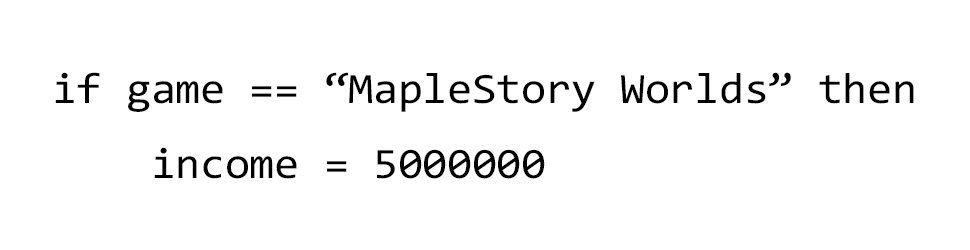

[Original Document Image]
Extracted Text (raw):
if game == “MapleStory Worlds” then
income = 5@e@eee0



In [3]:
# 예제 이미지 경로 (문서 이미지)
!wget 'https://tpc.googlesyndication.com/simgad/18042067972520092365?sqp=4sqPyQQ7QjkqNxABHQAAtEIgASgBMAk4A0DwkwlYAWBfcAKAAQGIAQGdAQAAgD-oAQGwAYCt4gS4AV_FAS2ynT4&rs=AOga4qkB6cyOx1FbhpmI-uYGnCDR5cJ-DA' -O '/content/sample_document.jpg'
image_path = '/content/sample_document.jpg'

# 이미지 읽기
img = cv2.imread(image_path)
if img is None:
    print(f"이미지를 불러올 수 없습니다: {image_path}")
else:
    cv2_imshow(img)
    print("[Original Document Image]")

    # Tesseract를 사용한 텍스트 추출
    text = pytesseract.image_to_string(img, lang='eng')  # 언어: 영어
    print("Extracted Text (raw):")
    print(text)

# 3. 이미지 전처리를 통한 성능 향상
**OCR 성능**은 이미지 품질(명암비, 해상도, 노이즈 등)에 크게 의존합니다.
OpenCV로 전처리를 수행하면, Tesseract의 인식 정확도를 높일 수 있습니다.

1. **그레이스케일 변환**: 컬러 → 흑백
2. **이진화**(Threshold): 텍스트 경계를 명확히
3. **노이즈 제거**(GaussianBlur, MedianBlur 등)
4. (선택) **모폴로지 연산**(열기/닫기), Skew 교정, 확대/축소

아래 코드는 **그레이스케일→이진화→블러** 순서로 전처리를 시연합니다.

[Gray]


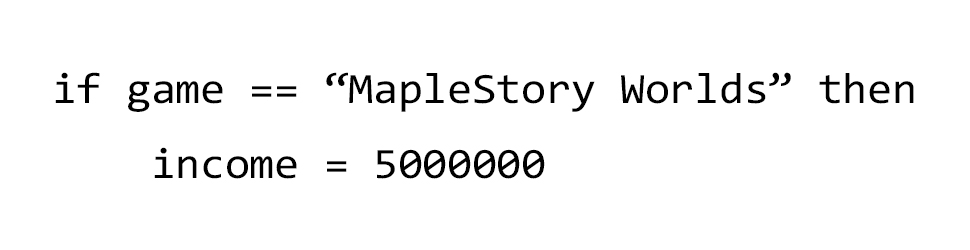

[Binary]


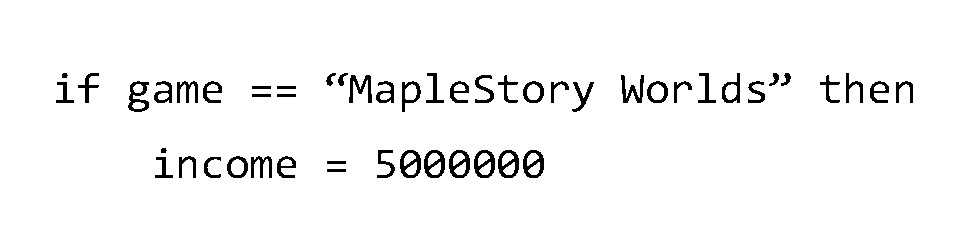

[Denoised]


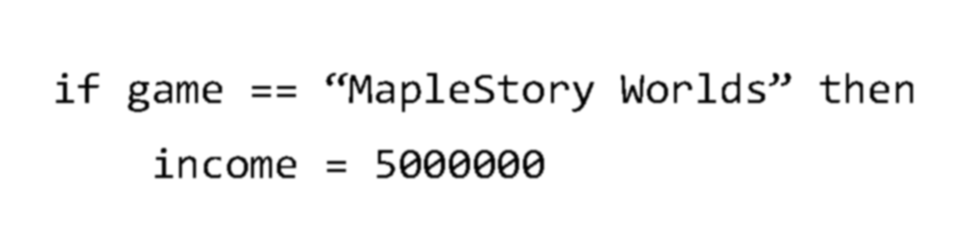

Processed Extracted Text:
if game == “MapleStory Worlds” then
income = 5000000



In [4]:
if img is not None:
    # 그레이스케일 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 간단한 임계값 이진화
    # 더 정교하게는 Otsu's threshold나 adaptiveThreshold 사용 가능
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # 노이즈 제거를 위해 가우시안 블러
    denoised = cv2.GaussianBlur(binary, (5,5), 0)

    # 결과 표시
    print("[Gray]")
    cv2_imshow(gray)
    print("[Binary]")
    cv2_imshow(binary)
    print("[Denoised]")
    cv2_imshow(denoised)

    # Tesseract로 전처리된 이미지에서 텍스트 추출
    text_processed = pytesseract.image_to_string(denoised, lang='eng')
    print("Processed Extracted Text:")
    print(text_processed)

### 추가 전처리 아이디어
- **Adaptive Threshold**: 글자 배경이 일정치 않을 때 사용
```python
adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, blockSize=31, C=5)
```
- **Otsu's Threshold**: 전체 히스토그램 분석
```python
_, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
```
- **Deskew(기울기 교정)**: HoughLines/P 등을 사용해 문서 수평 정렬.
- **Morphology**: 열기/닫기 연산으로 노이즈 제거 or 획 두께 보정.

# 4. 문서의 영역별 텍스트 추출
Tesseract는 **image_to_data** 또는 **image_to_boxes** 등을 통해 **텍스트의 위치/크기** 정보를 반환할 수 있습니다.

```python
data = pytesseract.image_to_data(img, lang='eng', output_type=pytesseract.Output.DICT)
```

- `left`, `top`, `width`, `height`, `conf`, `text` 등의 정보를 포함.
- `conf`(confidence)가 특정 값 이상인 경우만 시각화하는 등 활용 가능.

[Text regions with confidence > 50%]


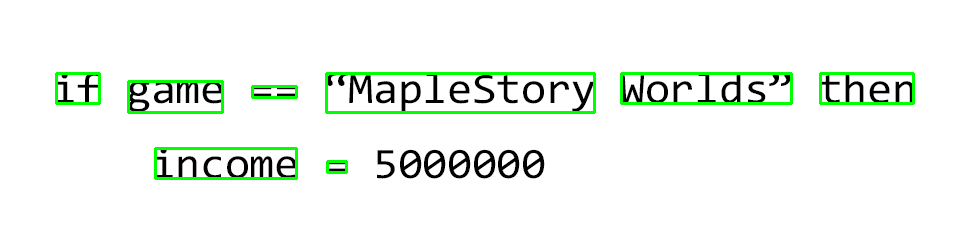

In [5]:
if img is not None:
    h, w, c = img.shape

    data = pytesseract.image_to_data(img, lang='eng', output_type=pytesseract.Output.DICT)
    n_boxes = len(data['text'])

    img_boxes = img.copy()
    for i in range(n_boxes):
        if int(data['conf'][i]) > 50:  # 신뢰도 50% 이상
            (x, y, bw, bh) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
            cv2.rectangle(img_boxes, (x, y), (x + bw, y + bh), (0, 255, 0), 2)

    print("[Text regions with confidence > 50%]")
    cv2_imshow(img_boxes)

# 5. 다국어 문서 인식
**Tesseract**는 다국어 지원을 위해 언어 모델( `.traineddata` )이 필요합니다.
- 언어 모델 설치 예 (한국어): `!sudo apt-get install tesseract-ocr-kor`
- `lang='kor+eng'` 처럼 다중 언어 동시 지정 가능.
아래는 한글 모델 설치 예시를 보여줍니다.

In [6]:
# 한국어 모델 설치 예시
# !sudo apt-get update -qq
# !sudo apt-get install -y tesseract-ocr-kor

# 다국어 OCR 예:
# text_multilang = pytesseract.image_to_string(img, lang='kor+eng')
# print(text_multilang)

print("예시: 한글 OCR을 사용하려면 'tesseract-ocr-kor' 패키지 설치 후 lang='kor' 지정")

예시: 한글 OCR을 사용하려면 'tesseract-ocr-kor' 패키지 설치 후 lang='kor' 지정


# 6. PDF 문서에서 텍스트 추출
PDF 파일을 직접 Tesseract로 처리할 수 없으므로, **pdf2image**로 각 페이지를 이미지로 변환한 뒤, OCR을 적용합니다.

```python
from pdf2image import convert_from_path
images = convert_from_path(pdf_path)
for i, page_img in enumerate(images):
    text = pytesseract.image_to_string(page_img, lang='eng')
```

아래는 간단한 시연 예제.

In [11]:
from pdf2image import convert_from_path

def ocr_from_pdf(pdf_path, lang='eng'):
    """PDF를 이미지로 변환 후, 각 페이지에서 OCR."""
    pages = convert_from_path(pdf_path)

    for i, page in enumerate(pages):
        # page는 PIL Image
        text = pytesseract.image_to_string(page, lang=lang)
        print(f"[Page {i+1} Text]:\n{text}\n")

# 예시
# pdf_path = '/content/sample_document.pdf'
# ocr_from_pdf(pdf_path, lang='eng')

# 7. 과제
아래 과제들을 통해 **OCR**과 **OpenCV**를 더욱 효과적으로 활용해 보세요.

1. **Otsu / AdaptiveThreshold**
   - 단순 threshold(150) 대신, `cv2.THRESH_OTSU` 나 `cv2.adaptiveThreshold`를 사용하여 전처리 결과를 비교.

2. **Deskew(기울기 교정)**
   - 문서가 기울어져 있으면 인식이 떨어질 수 있음.
   - HoughLines 등을 이용해 기울기를 구한 뒤, `cv2.warpAffine`으로 보정 후 OCR.

3. **Morphology**
   - `cv2.morphologyEx` (열기/닫기/Gradient)로 노이즈나 글자 끊김을 보정.

4. **영역별 폰트 크기 다른 문서**
   - `pytesseract.image_to_data`를 사용해, 글자 크기와 위치를 분석해 보세요.

5. **성능 평가**
   - 다수 문서(예: 10장)에서 추출된 텍스트와 실제 정답을 비교해 정확도(Word Error Rate 등)를 측정.


## 7.1 과제 결과 예시 코드: Otsu Threshold & Deskew
간단한 **Otsu Threshold**와 **Deskew(기울기 보정)** 예시를 추가로 보여드립니다.

In [12]:
def otsu_threshold_ocr_colab(image_path, lang='eng'):
    img = cv2.imread(image_path)
    if img is None:
        print(f"이미지를 불러올 수 없습니다: {image_path}")
        return
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Otsu Threshold
    _, otsu_bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    print("[Otsu Binarized Image]")
    cv2_imshow(otsu_bin)

    text_otsu = pytesseract.image_to_string(otsu_bin, lang=lang)
    print("[OCR Result with Otsu Threshold]")
    print(text_otsu)

# Deskew (기울기 보정) 예시 (간단한 방법)
# 실제로는 HoughLinesP등으로 문서 중심선 찾거나, minAreaRect등을 사용
def deskew_colab(image_path, lang='eng'):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"이미지를 불러올 수 없습니다: {image_path}")
        return
    # binary
    _, bin_ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # 컨투어나 모멘트 기반 기울기 계산(아주 간단한 예)
    coords = np.column_stack(np.where(bin_>0))
    angle = cv2.minAreaRect(coords)[-1]  # box angle
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h,w) = img.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w,h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    print(f"[Deskew angle: {angle:.2f} degrees]")
    cv2_imshow(rotated)

    text_deskewed = pytesseract.image_to_string(rotated, lang=lang)
    print("[OCR Result from Deskewed Image]")
    print(text_deskewed)


# 8. 강의 요약
1. **Tesseract** 설치 및 `pytesseract`를 활용해 문서 이미지에서 텍스트를 추출.
2. **이미지 전처리** (그레이스케일, 이진화, 노이즈 제거 등)로 인식 정확도 향상.
3. **영역별 텍스트 인식**: `image_to_data`를 사용해 위치/크기/신뢰도 정보 얻기.
4. **다국어 지원**: 추가 언어 모델 설치 후 `lang='kor+eng'` 등 설정.
5. **PDF 문서**: `pdf2image`로 페이지 단위 이미지 변환 후 OCR.
6. 추가로 **Deskew**, **Morphology**, **Adaptive Threshold** 등 고급 전처리를 적용하면 더욱 정확도를 높일 수 있음.

이 노트북을 기반으로, **다양한 문서**(스캔, 사진 등)에 대한 OCR 실습을 해 보시기 바랍니다!